In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [318]:
n = 100
mu_const = np.random.randn(n) # Одиноковым должен быть, для всех последовательных измерений

In [390]:
from numpy.linalg import inv

color_list = ['b', 'brown', 'g', 'r', 'black', 'gray']
class generate_model(object):
    
    def __init__(self, n = n, sigma = 0.05, several = False):
        self._n = n
        self._B = None
        self._mu = None
        self._F = None
        self._A = None
        self._S = np.identity(n) * sigma ** 2
        self._sigma = sigma
        self._x0 = np.zeros((n, )) # В случае белого шума
        self._several = several
        
    def generate_wnoise(self):
        if self._mu is not None:
            return self
        if not self._several:
            self._mu = np.random.randn(self._n) 
        else:
            self._mu = mu_const
    
    def create_operator_B(self, l = 5):
        # при создании оператора B в случае надобности создаём априорную информацию
        # Оператор B сглаживание усреднением в окне ширины l
        if self._B is not None:
            return self
        self._B = np.zeros((self._n - l + 1, self._n))
        for idx in range(self._n - l + 1):
            self._B[idx][idx: idx + l] = 1.
        self._B = (1/l) * self._B
        for idx in range(l - 1, 0, -1):
            dop = np.zeros((self._n, ))
            dop[self._n - idx: ] = (1/idx) 
            self._B = np.concatenate((self._B, dop[None, :]))
        self._F = np.dot(self._B, self._B.T)
    
    def get_x(self):
        if self._B is None or self._mu is None:
            self.create_operator_B() # l default
            self.generate_wnoise() # too default params
        return np.dot(self._B, self._mu)
    
    def create_A(self):
        if self._A is not None:
            return self
        # A should be 
        # Сделаем матрицу A некоторой случайной 
        self._A = np.zeros((self._n, self._n))
        self._A = np.random.randint(-10, 10, size = self._n * self._n).reshape((self._n, self._n))/10
        
    def get_y(self):
        if self._A is None or self._B is None or self._mu is None:
            self.create_operator_B()
            self.generate_wnoise()
            self.create_A()
        self._y = np.dot(self._A, self.get_x()) + np.random.randn(self._n) * self._sigma
        return self._y
    
    def get_single_pack_data(self):
        y = self.get_y()
        A = self._A
        S = self._S
        return (y, A, S)
    
    def get_est_x(self):
        # даст оценку с учётом априорного знания 
        A = self._A
        S = self._S
        F = self._F
        
        Q = inv(np.dot(A.T, np.dot(inv(S), A)) + inv(F))
        est_x = np.dot(Q, np.dot(np.dot(A.T, inv(S)), self._y) + np.dot(inv(F), self._x0))
        return est_x
    
    def get_std_deviation(self):
        # Даст стандартное отклонение с учётом априорного знания 
        A = self._A
        S = self._S
        F = self._F
        
        Q = inv(np.dot(A.T, np.dot(inv(S), A)) + inv(F))
        d = np.asarray([np.sqrt(Q[idx, idx]) for idx in range(Q.shape[0])])
        return d
        
    @staticmethod
    def show_graphs(**signals):
        fig, ax = plt.subplots(figsize = (14, 7))
        idx = 0
        sigma  = None
        for name, signal in signals.items():
            if name != 'sigma':
                lenght = len(signal)
                if 'plus' in name or 'minus' in name:
                    ax.plot(list(range(lenght)), signal, 
                            c = 'black',
                            label = name, linewidth = 1. if 'plus' in name or 'minus' in name else 1.5, 
                            linestyle = '-.' if 'plus' in name or 'minus' in name else '-')
                else:
                    ax.plot(list(range(lenght)), signal, 
                            c = color_list[idx] if idx < len(color_list) else color_list[idx % len(color_list)],
                            label = name, linewidth = 1. if 'plus' in name or 'minus' in name else 1.5, 
                            linestyle = '-.' if 'plus' in name or 'minus' in name else '-')
                ax.legend()
                idx += 1
            else:
                sigma = signal
            
            
        ax.grid()
        ax.set_xlabel('Отсчёты x_i')
        ax.set_ylabel('Отклонения')
        if sigma is not None:
            ax.set_title('noise of sigma = {}'.format(sigma))
        
        

In [391]:
def generate_several_data_packs(N = 3, samples = (100, 100, 100, 100, 100), sigmas = (0.8, 0.4, 0.5, 0.7, 1., 0.6)):
    cls_list = []
    if(N > 5):
        print('N > 5! Because we would use only 5 data objects!')
    # генерация с разными A_i and S_{i} число отсчётов рекомендовано для простоты брать одинаковым
    for item in range(N):
        cls_current = generate_model(n = samples[item], sigma = sigmas[item], several=True) # Чтобы для одного и того же mu
        cls_list.append(cls_current)
        
    return cls_list
        
        

In [392]:
def data_to_canonicalINFO(y, A, S):
    # return (T, v) - CI for single data
    T = np.dot(A.T, np.dot(inv(S), A))
    v = np.dot(A.T, np.dot(inv(S), y))
    return (T, v)

def priordata_to_canonicalINFO(x_0, F_0):
    return (inv(F_0), np.dot(inv(F_0), x_0)) # (T_0, v_0)

def estimate_single(CI):
    # return (est_x, D(x - est_x)) for single data
    T, v = CI 
    return (np.dot(inv(T), v), inv(T))
def update_sum_CI(CI1, CI2):
    # CI : (T, v)
    return (CI1[0] + CI2[0], CI1[1] + CI2[1])

In [393]:
def get_estimate(list_data_objs, with_prior_info = False):
    if(len(list_data_objs) == 1):
        # single data
        print('single data estimate')
        data_obj = list_data_objs[-1]
        y, A, S = data_obj.get_single_pack_data()
        CI = data_to_canonicalINFO(y, A, S)  # (T, v) without prior information
        if(with_prior_info): # with prior info
            print('with prior info')
            x_0, F_0 = data_obj._x0, data_obj._F
            CI_prior = priordata_to_canonicalINFO(x_0, F_0)
            CI_with_prior = update_sum_CI(CI, CI_prior)
            est_x, d_est = estimate_single(CI_with_prior)
        else:  # Without prior info
            print('without prior info')
            est_x, d_est = estimate_single(CI)
        d_est = np.asarray([np.sqrt(d_est[idx, idx]) for idx in range(data_obj._n)])
        data_obj.show_graphs(x = data_obj.get_x(), est_x = est_x, dev_plus = est_x + d_est / 2, 
                                             dev_minus = est_x - d_est / 2, sigma = data_obj._sigma)
            
    else:
        # several data
        print('Several data')
        for idx, obj in enumerate(list_data_objs):
            y, A, S = obj.get_single_pack_data()
            if(idx == 0):
                if(with_prior_info):
                    print('with prior info')
                    x_0, F_0 = obj._x0, obj._F # Они уже созданы, так как я вызвал get_single_pack
                    CI0 = priordata_to_canonicalINFO(x_0, F_0)
                    n = obj._n
                    x = obj.get_x()
                else:
                    print('without prior info')
                    n = obj._n
                    x = obj.get_x()
                    CI0 = (np.zeros((obj._n, obj._n)), np.zeros((obj._n, )))# empty CI размерность будет соответтсвовать ((n, n), (n))
            CI = data_to_canonicalINFO(y, A, S)
            CI0 = update_sum_CI(CI0, CI)
                
        est_x, d_est = estimate_single(CI0) # Оно будет тоже как от одного формально
   
        d_est = np.asarray([np.sqrt(d_est[idx, idx]) for idx in range(n)])
        obj_for_show = generate_model()
        obj_for_show.show_graphs(x = x, est_x = est_x, dev_plus = est_x + d_est / 2, 
                                             dev_minus = est_x - d_est / 2)
            

single data estimate
without prior info


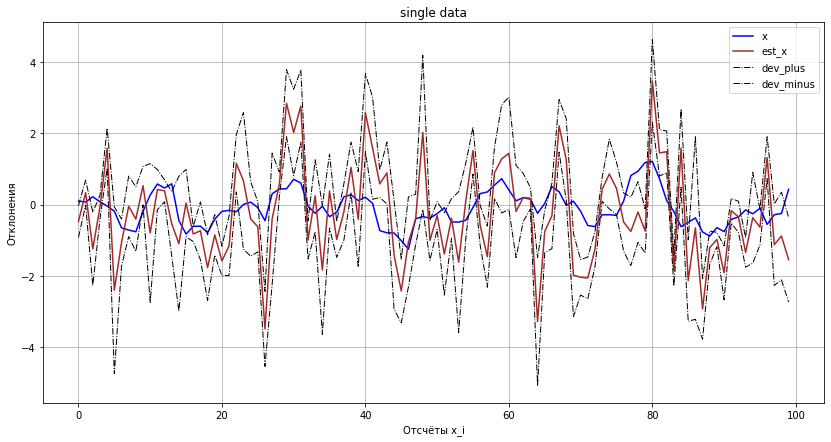

In [394]:
N = 1 # Wihtout prior information
list_of_data_obj = generate_several_data_packs(N = N) # Генерируем одно измерение для канонической информации
get_estimate(list_of_data_obj, with_prior_info = False)
ax = plt.gca()
ax.set_title('several data {}'.format(N) if N > 1 else "single data");

single data estimate
with prior info


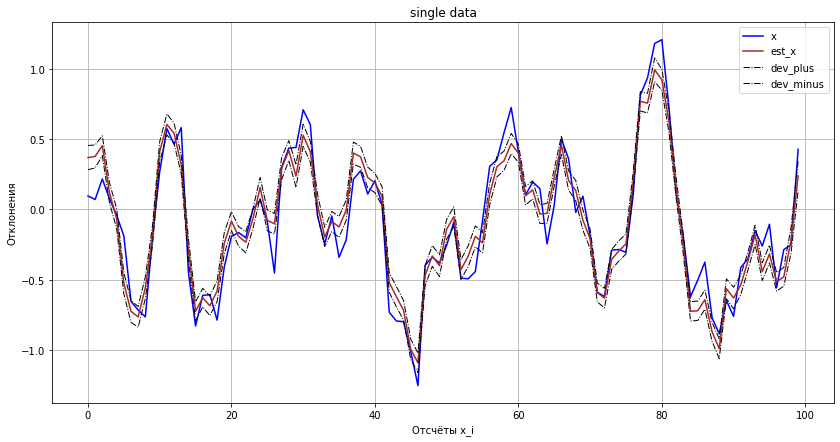

In [395]:
N = 1 # Without prior information
list_of_data_obj = generate_several_data_packs(N = N) # Генерируем одно измерение для канонической информации
get_estimate(list_of_data_obj, with_prior_info = True)
ax = plt.gca()
ax.set_title('several data {}'.format(N) if N > 1 else "single data");

Several data
without prior info


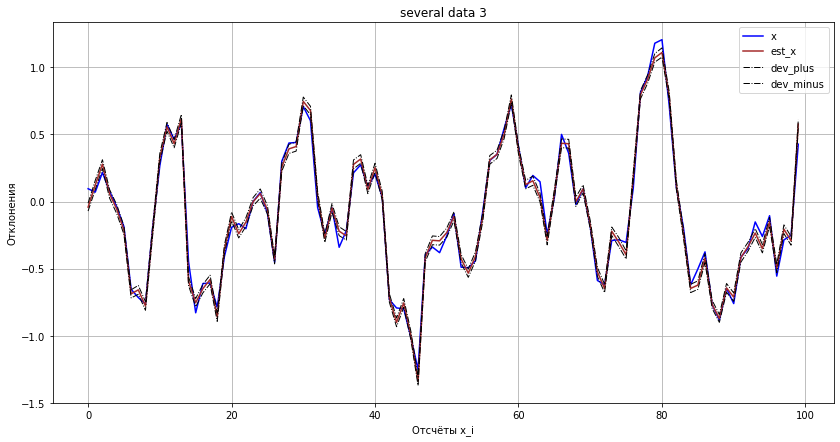

In [396]:
N = 3
list_of_data_obj = generate_several_data_packs(N = N) # Генерируем одно измерение для канонической информации
get_estimate(list_of_data_obj, with_prior_info = False)
ax = plt.gca()
ax.set_title('several data {}'.format(N) if N > 1 else "single data");

Several data
with prior info


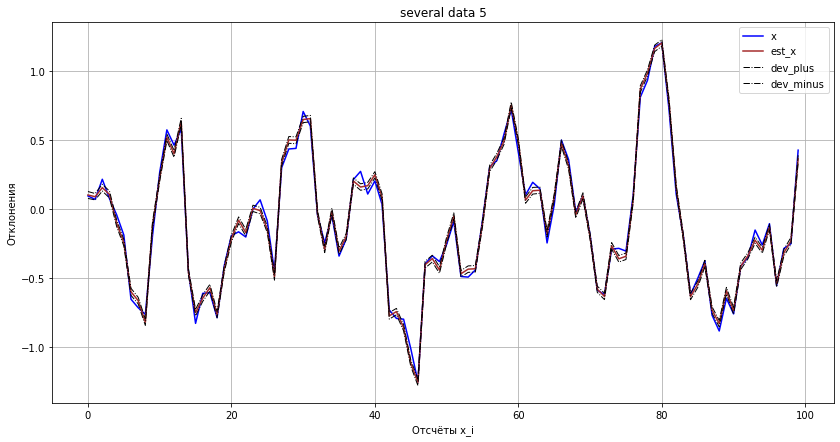

In [397]:
N = 5 # With prior information 
list_of_data_obj = generate_several_data_packs(N = N) # Генерируем одно измерение для канонической информации
get_estimate(list_of_data_obj, with_prior_info = True)
ax = plt.gca()
ax.set_title('several data {}'.format(N) if N > 1 else "single data");